In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import the dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms
from torchvision.datasets import FashionMNIST
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

### Download the dataset

In [2]:
dataset = FashionMNIST(root = "/content/drive/MyDrive/Deep Learning/pytorch_zero_to_gans/data", download = True)

In [3]:
test = FashionMNIST(root = "/content/drive/MyDrive/Deep Learning/pytorch_zero_to_gans/data", train = False)

### Checking the number of main dataset and test

In [4]:
len(dataset), len(test)

(60000, 10000)

### The class names

In [5]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Label Ankle Boot


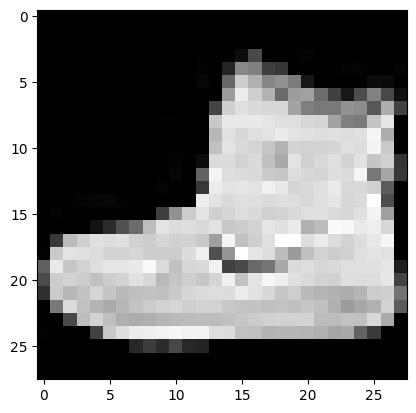

In [6]:
# Lets check what is entailed in the train and test
image, label = dataset[0]
plt.imshow(image, cmap = 'gray')
print('Label',output_label(label))

Label T-shirt/Top


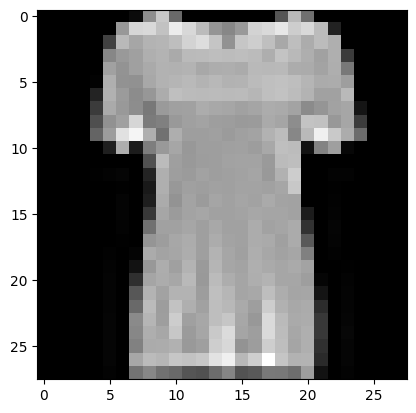

In [7]:
image, label = dataset[10]
plt.imshow(image, cmap = 'gray')
print("Label", output_label(label))

Label Sandal


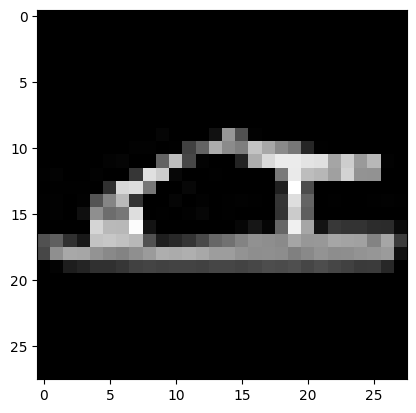

In [8]:
image, label = dataset[120]
plt.imshow(image, cmap = 'gray')
print("Label", output_label(label))

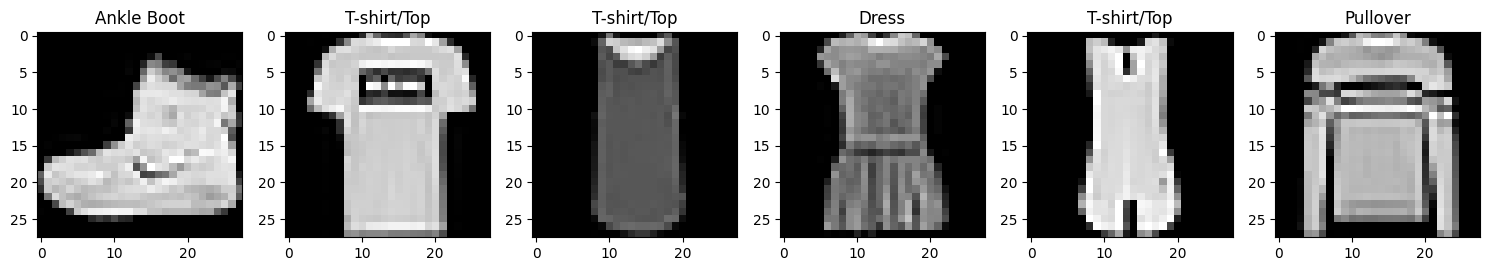

In [9]:
plt.figure(figsize = (15, 10))
for i in range(6):
  image, label = dataset[i]
  ax = plt.subplot(1, 6, i+1)
  ax.imshow(image, cmap = 'gray')
  plt.tight_layout()
  plt.title(output_label(label))

### Converting the images to tensors

In [10]:
dataset = FashionMNIST(root = "/content/drive/MyDrive/Deep Learning/pytorch_zero_to_gans/data", train = True,
                        transform = transforms.ToTensor())

In [11]:
test = FashionMNIST(root = "/content/drive/MyDrive/Deep Learning/pytorch_zero_to_gans/data", train = False,
                        transform = transforms.ToTensor())

In [12]:
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Deep Learning/pytorch_zero_to_gans/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Deep Learning/pytorch_zero_to_gans/data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Splitting the dataset into train and validation using the RandomSampler

In [14]:
from torch.utils.data import random_split, DataLoader

train_ds, val_ds = random_split(dataset, [50000, 10000])

### Loading the datasets using the DataLoader

In [15]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

In [16]:
len(train_loader), len(val_loader)

(391, 79)

In [17]:
input_size = 28 * 28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [18]:
model.weight.shape

torch.Size([10, 784])

In [19]:
model.bias.shape

torch.Size([10])

### Creating a function for accuracy

In [20]:
def accuracy(output, label):
  preds = F.softmax(output, dim = 1)
  _, pred = torch.max(preds, dim = 1)
  return torch.tensor(torch.sum(pred == label).item() / len(pred))

## Creating and extending the ability of the model

In [21]:
import torch.nn.functional as F

class fashionMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    output = self.linear(xb)
    return output

  def training_step(self, batch):
    images, labels = batch
    output = self(images)
    loss = F.cross_entropy(output, labels)
    return loss

  def validation_step(self, batch):
    image, label = batch
    output = self(image)
    loss = F.cross_entropy(output, label)
    acc = accuracy(output, label)
    return {'val_loss' : loss, 'val_acc' : acc}

  def validation_epoch_end(self, output):
    loss = [x['val_loss'] for x in output]
    accuracy = [x['val_acc'] for x in output]
    val_loss = torch.stack(loss).mean()
    val_acc = torch.stack(accuracy).mean()
    return {'val_loss' : val_loss, 'val_acc' : val_acc}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], val_loss : {result['val_loss']:.4f}, val_acc : {result['val_acc']:.4f}")


model = fashionMNIST()

## Evaluation

In [22]:
def evaluate(model, batches):
  output = [model.validation_step(input) for input in batches]
  return model.validation_epoch_end(output)

In [23]:
def fit(epochs, train_loader, val_loader, lr, optim = torch.optim.SGD):
  history = []

  optimizer = optim(model.parameters(), lr)
  for epoch in range(epochs):

    # Training step
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Evaluation step
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)


### Fit the model

In [24]:
epochs = 20
history1 = fit(epochs, train_loader, val_loader, 0.01)

Epoch [0], val_loss : 0.9007, val_acc : 0.7133
Epoch [1], val_loss : 0.7659, val_acc : 0.7563
Epoch [2], val_loss : 0.7019, val_acc : 0.7822
Epoch [3], val_loss : 0.6626, val_acc : 0.7945
Epoch [4], val_loss : 0.6341, val_acc : 0.8054
Epoch [5], val_loss : 0.6140, val_acc : 0.8081
Epoch [6], val_loss : 0.5984, val_acc : 0.8117
Epoch [7], val_loss : 0.5838, val_acc : 0.8137
Epoch [8], val_loss : 0.5727, val_acc : 0.8167
Epoch [9], val_loss : 0.5627, val_acc : 0.8219
Epoch [10], val_loss : 0.5566, val_acc : 0.8201
Epoch [11], val_loss : 0.5472, val_acc : 0.8235
Epoch [12], val_loss : 0.5430, val_acc : 0.8229
Epoch [13], val_loss : 0.5345, val_acc : 0.8259
Epoch [14], val_loss : 0.5292, val_acc : 0.8278
Epoch [15], val_loss : 0.5260, val_acc : 0.8275
Epoch [16], val_loss : 0.5204, val_acc : 0.8287
Epoch [17], val_loss : 0.5162, val_acc : 0.8302
Epoch [18], val_loss : 0.5118, val_acc : 0.8310
Epoch [19], val_loss : 0.5090, val_acc : 0.8303


### Test the model using the test dataset

In [25]:
test_dataset = FashionMNIST(root = "/content/drive/MyDrive/Deep Learning/pytorch_zero_to_gans/data", train = False,
                        transform = transforms.ToTensor())

In [26]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Deep Learning/pytorch_zero_to_gans/data
    Split: Test
    StandardTransform
Transform: ToTensor()

torch.Size([1, 28, 28])
Label:  Ankle Boot


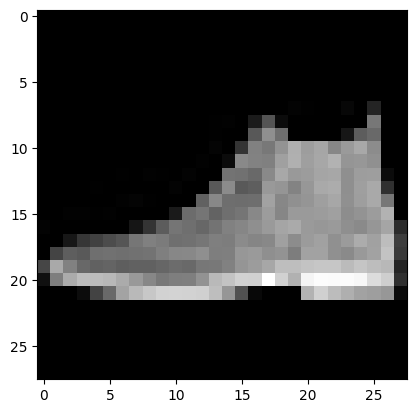

In [33]:
image, label  = test_dataset[0]
plt.imshow(image[0], cmap = 'gray')
print(image.shape)
print('Label: ', output_label(label))

img.unsqueeze simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28
tensor, which the model views as a batch containing a single image.

In [38]:
def predict_image(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  preds = F.softmax(yb, dim = 1)
  _, pred = torch.max(preds, dim = 1)
  return pred[0].item()

torch.Size([1, 28, 28])
Actual label: Ankle Boot, Predicted label: Ankle Boot


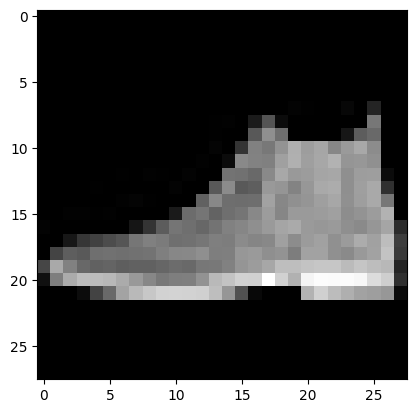

In [39]:
image, label  = test_dataset[0]
plt.imshow(image[0], cmap = 'gray')
print(image.shape)
print(f'Actual label: {output_label(label)}, Predicted label: {output_label(predict_image(image, model))}')

torch.Size([1, 28, 28])
Actual label: Dress, Predicted label: Dress


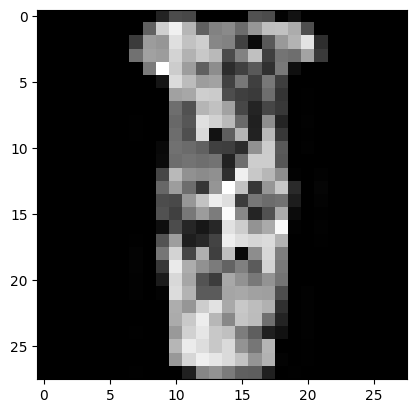

In [40]:
image, label  = test_dataset[100]
plt.imshow(image[0], cmap = 'gray')
print(image.shape)
print(f'Actual label: {output_label(label)}, Predicted label: {output_label(predict_image(image, model))}')

torch.Size([1, 28, 28])
Actual label: Coat, Predicted label: Coat


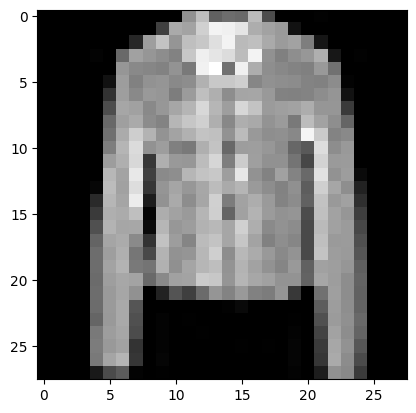

In [41]:
image, label  = test_dataset[10]
plt.imshow(image[0], cmap = 'gray')
print(image.shape)
print(f'Actual label: {output_label(label)}, Predicted label: {output_label(predict_image(image, model))}')

torch.Size([1, 28, 28])
Actual label: T-shirt/Top, Predicted label: T-shirt/Top


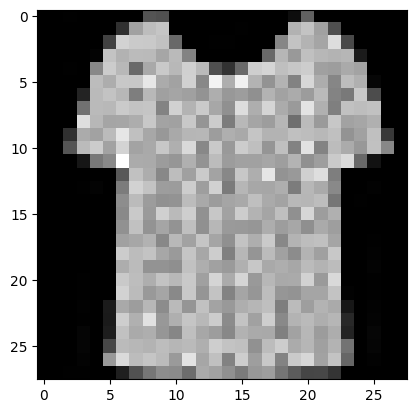

In [42]:
image, label  = test_dataset[1000]
plt.imshow(image[0], cmap = 'gray')
print(image.shape)
print(f'Actual label: {output_label(label)}, Predicted label: {output_label(predict_image(image, model))}')